https://molefrog.github.io/pidnn-talk/#pidnn-controller

Use neural network to generate PID parameters. Neural network is trained using a model of the plant so we don't need to know jacobian of plant. Model is trained on plant outputs offline.

V3.1 PID neural network takes in previous y value as parameter

V3.2 Take absolute value of Kp, Ki, Kd

V3.3 PID control the plant while training with a manually tuned PID controller

V3.4 Remove 3.3 changes. Initialize bias term with ones

V3.5 Added another layer to model neural network. Initialized only model nn with zeros. Increased NN model size to 16

V3.6 Changed to Adam Optimizer. Increased model to 3 layers: 16, 8 ,4. Added 10 epochs. Lowered learning rate

V3.7 Allowing model nn weight updates in online training

V3.8 Remove 3.7 changes. Added layer to PID nn: 8, 3. Switched to leaky relu in model nn

In [3]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
import tensorflow as tf
from tensorflow.python.framework import ops

In [4]:
from simulation_tools import Servo, simulation_init

### Plant control with neural network

In [5]:
class Servo_Interface():

    def __init__(self):
        self.servo = Servo("rotation", 0.32, 0.06, 0.00879)
        
    def set_inputs(self, y0, cur_angle, t, r, d):
        self.y0 = y0
        self.cur_angle = cur_angle
        self.t = t
        self.r = r
        self.d = d
        
    def update(self, Kp, Ki, Kd):
        if Kp is not None and Ki is not None and Kd is not None:
            self.servo.PID.update_gains(Kp, Ki, Kd)
        self.state, self.angle = self.servo.simulate_step(self.y0, self.cur_angle, self.t, self.r, self.d)
        return self.servo.PID.u
    
    def d_update(self, Kp, Ki, Kd):
        return np.float32(self.servo.PID.P), np.float32(self.servo.PID.I), np.float32(self.servo.PID.D)
    

In [44]:
si = Servo_Interface()


np_update = np.vectorize(si.update)
np_d_update = np.vectorize(si.d_update)

def tf_d_update(Kp, Ki, Kd,name=None):
    with tf.name_scope(name, "d_update", [Kp, Ki, Kd]) as name:
        y = tf.py_func(np_d_update,
                        [Kp, Ki, Kd],
                        (tf.float32, tf.float32, tf.float32),
                        name=name,
                        stateful=False)
        return y

def py_func(func, inp, Tout, stateful=True, name=None, grad=None):

    # Need to generate a unique name to avoid duplicates:
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+8))

    tf.RegisterGradient(rnd_name)(grad)  # see _MySquareGrad for grad example
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)
    
def updategrad(op, grad):
    Kp, Ki, Kd = op.inputs
    
    dudKp, dudKi, dudKd = tf_d_update(Kp, Ki, Kd)
    return grad * dudKp, grad * dudKi, grad * dudKd


def tf_update(Kp, Ki, Kd, name=None):

    with tf.name_scope(name, "update", [Kp, Ki, Kd]) as name:
        y = py_func(np_update,
                        [Kp, Ki, Kd],
                        [tf.float32],
                        name=name,
                        grad=updategrad)  # <-- here's the call to the gradient
        return y

graph = tf.Graph()
with graph.as_default():
    
    tf_control_sig = tf.placeholder(tf.float32, shape=())
    tf_dy_prev = tf.placeholder(tf.float32, shape=())
    tf_y_prev = tf.placeholder(tf.float32, shape=())
    tf_dy_next = tf.placeholder(tf.float32, shape=())
    tf_y_next = tf.placeholder(tf.float32, shape=())


    tf_lr = tf.placeholder(tf.float32, shape=())
  
    def init_weights(layers, weights, biases, output_dim, bias_ones=False):         
        for i in range(len(layers)):
            if i < len(layers) - 1:
                weights.append(tf.Variable(tf.truncated_normal([layers[i], layers[i+1]])))
                if bias_ones:
                    biases.append(tf.Variable(tf.ones([layers[i+1]])))
                else:
                    biases.append(tf.Variable(tf.zeros([layers[i+1]])))

            else:
                weights.append(tf.Variable(tf.truncated_normal([layers[i], output_dim])))
                if bias_ones:
                    biases.append(tf.Variable(tf.ones([output_dim])))
                else:
                    biases.append(tf.Variable(tf.zeros([output_dim])))
    # Model NN    
    #include input
    m_layers = [3, 5]


    m_weights = []
    m_biases = []
    init_weights(m_layers, m_weights, m_biases, 2)

        
    # PID param NN
    #include input
    p_layers = [2, 4, 3]

    p_weights = []
    p_biases = []

    
    init_weights(p_layers, p_weights, p_biases, 3)

    def forward_prop(input_value, layers, weights, biases):
        for i in range(len(layers)):  
            if i == 0:
                z = tf.matmul(input_value, weights[i]) + biases[i]
            else:
                z = tf.matmul(a, weights[i]) + biases[i]
            if i < len(layers) - 1:
                a = tf.nn.leaky_relu(z)
        return z
    
    model_input = tf.reshape(tf.stack([tf_control_sig, tf_dy_prev, tf_y_prev], 0), (1, 3))
    model_output = forward_prop(model_input, m_layers, m_weights, m_biases)

    model_var_list = m_weights + m_biases
    model_label = tf.reshape(tf.stack([tf_dy_next, tf_y_next], 0), (1, 2))
    model_loss = tf.losses.mean_squared_error(model_label, model_output)
    model_opt = tf.train.AdamOptimizer(tf_lr).minimize(model_loss, var_list=model_var_list)
    


5.1475523e-05
5.0255774e-05
5.949536e-05
5.8804053e-05
6.0845457e-05
5.7821842e-05
5.3654745e-05
4.9230075e-05
3.8694605e-05
3.995906e-05


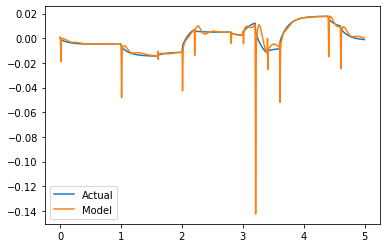

In [45]:
T, r, d, d_test, y0 = simulation_init(0.005, 5, 2)
epochs = 10

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for j in range(epochs):
        si.servo.PID.reset()
        dy = np.zeros(len(T))
        y = np.zeros(len(T))
        angle = np.zeros(len(T))
        
        dy[0] = y0[0]
        y[0] = y0[1]
        angle[0] = y[0] * 180/math.pi + 180
        
        model_state = np.zeros((len(T), 2))
        
        for i in range(1, len(T)):
            si.set_inputs([dy[i-1], y[i-1]], angle[i-1], [T[i-1], T[i]], r[i], d[i])
            u = si.update(None, None, None) * math.pi/180 + y[i-1]
            dy[i] = si.state[0]
            y[i] = si.state[1]
            angle[i] = si.angle
            feed_dict = {tf_control_sig:u, tf_dy_prev:dy[i-1], tf_y_prev:y[i-1], tf_dy_next:dy[i], tf_y_next:y[i], tf_lr:0.001}
            _, loss, model_state[i,:] = session.run([model_opt, model_loss, model_output], feed_dict=feed_dict)

        print(loss)

    plt.plot(T, y)
    plt.plot(T, model_state[:, 1])
    plt.legend(["Actual", "Model"])
    plt.show()